In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pickle

In [2]:
def wrangle(path):
    df = pd.read_csv(path)
    df.dropna(inplace = True)
    df.drop(columns=["instance_id", "acousticness", "loudness", "valence", "energy", 
                     "obtained_date", "track_name", "artist_name", "tempo"], inplace=True)
    
    for column in df.select_dtypes(include=["float", "int"]).columns:
        df[column] = (df[column] / np.max(df[column]))  
                       
    return df

In [3]:
df = wrangle("music_genre.csv")
print(df.shape)
df.info()
df.head(2)

(50000, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   danceability      50000 non-null  float64
 2   duration_ms       50000 non-null  float64
 3   instrumentalness  50000 non-null  float64
 4   key               50000 non-null  object 
 5   liveness          50000 non-null  float64
 6   mode              50000 non-null  object 
 7   speechiness       50000 non-null  float64
 8   music_genre       50000 non-null  object 
dtypes: float64(6), object(3)
memory usage: 3.8+ MB


,popularity,danceability,duration_ms,instrumentalness,key,liveness,mode,speechiness,music_genre
0,0.272727,0.661258,-2.070134e-07,0.795181,A#,0.115,Minor,0.079406,Electronic
1,0.313131,0.630832,4.518957e-02,0.953815,D,0.124,Minor,0.031847,Electronic


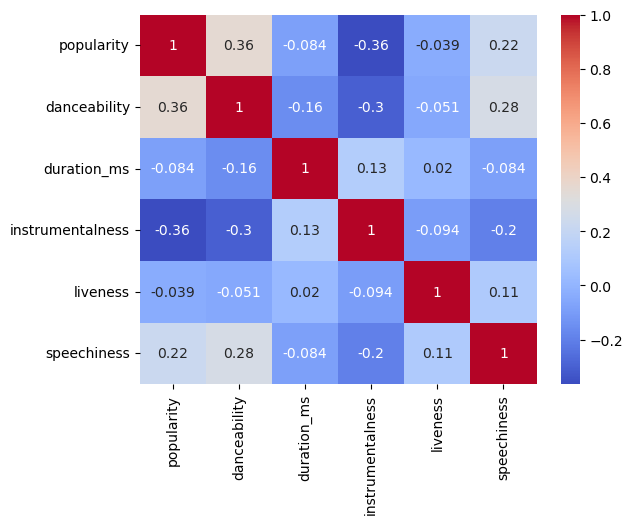

In [5]:
numerical_data = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

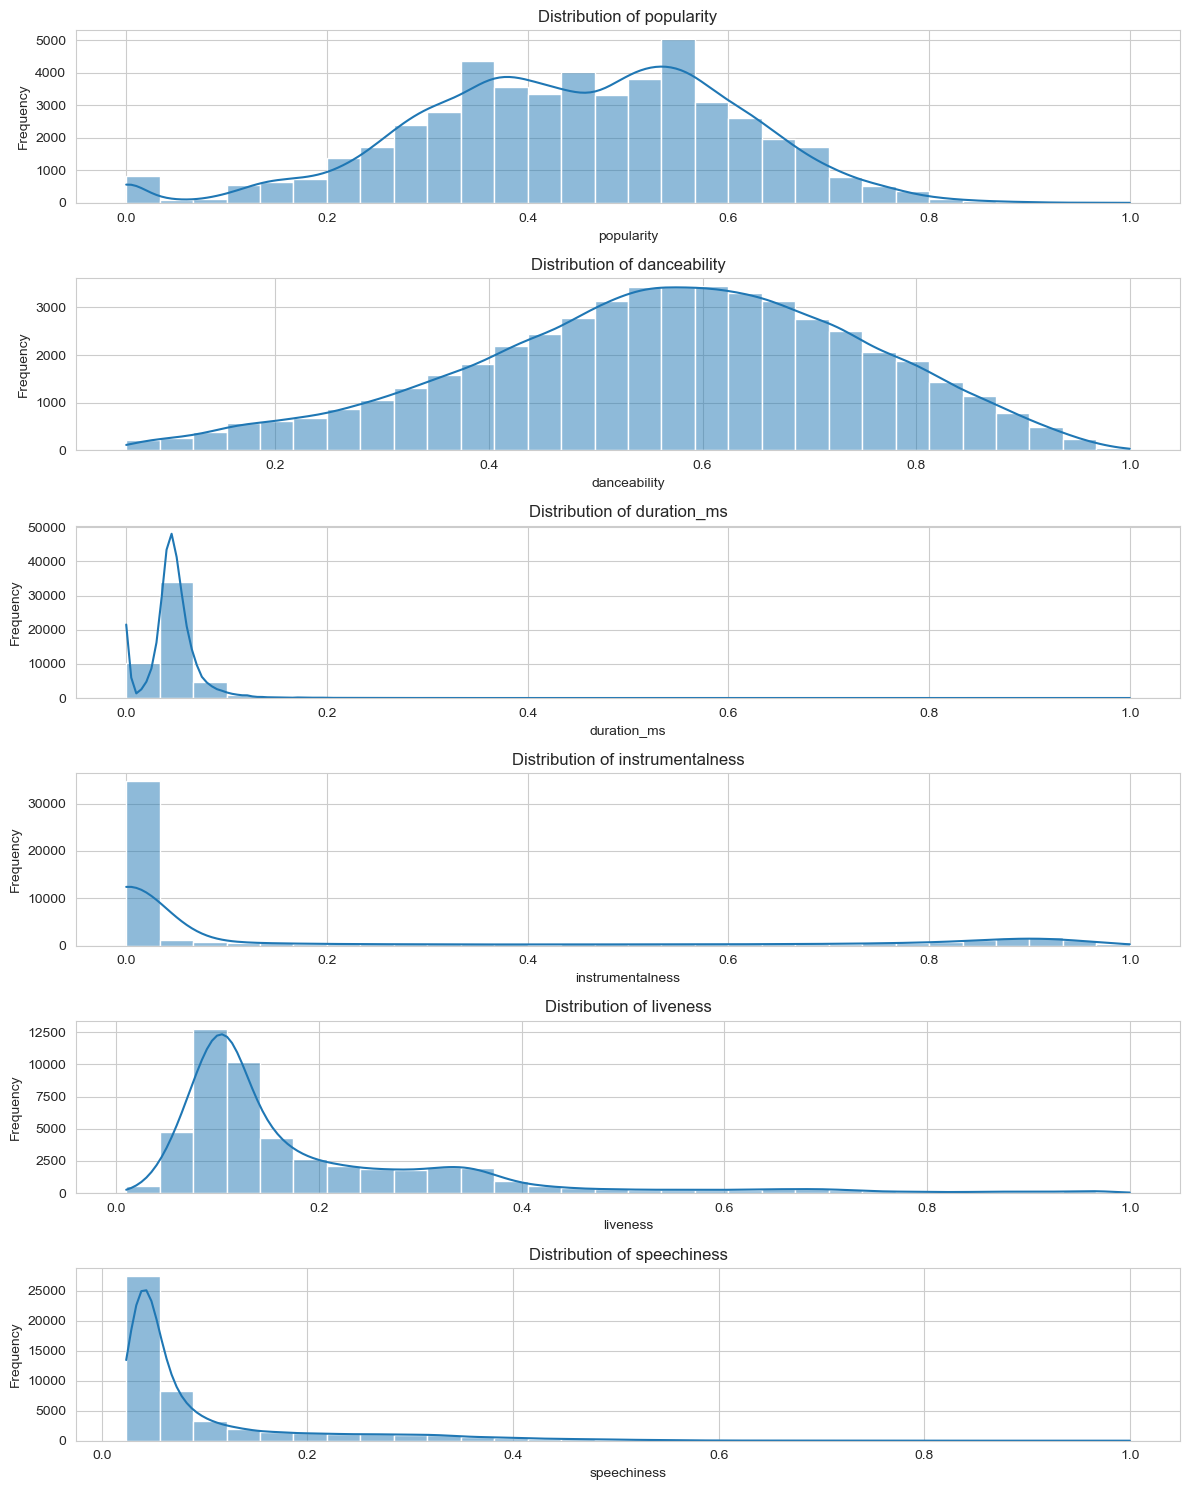

In [6]:
# Setting the aesthetics for the plots
sns.set_style("whitegrid")

# Creating a list of features to visualize
features_to_visualize = df.select_dtypes(include=["float", "int"]).columns.to_list()

# Setting up the figure and axes
fig, axes = plt.subplots(nrows=len(features_to_visualize), figsize=(12, 15))

# Plotting the distribution for each feature
for i, feature in enumerate(features_to_visualize):
    sns.histplot(df[feature], ax=axes[i], bins=30, kde=True)
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

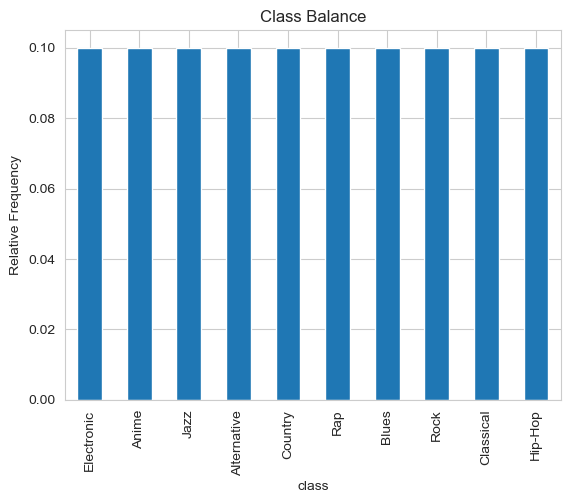

In [7]:
df["music_genre"].value_counts(normalize = True).plot(
        kind="bar", xlabel="class", ylabel="Relative Frequency", title="Class Balance"
    );

In [26]:
df["music_genre"].unique()

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [9]:
target = "music_genre"
X = df.drop(columns=target)
y = df[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Base line value using accuracy score
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.1011


In [23]:
model_dt = Pipeline(steps=[
    ('onehot', OneHotEncoder(use_cat_names=True)),
    ('decisiontree', DecisionTreeClassifier(random_state=42, max_depth=7))
])

model_dt.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 OneHotEncoder(cols=['key', 'mode'], use_cat_names=True)),
                ('decisiontree',
                 DecisionTreeClassifier(max_depth=7, random_state=42))])

In [24]:
acc_train = model_dt.score(X_train, y_train)
acc_test = model_dt.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 3))
print("Test Accuracy:", round(acc_test, 3))

Training Accuracy: 0.491
Test Accuracy: 0.475


In [30]:
y_pred_dt = model_dt.predict(X_test)
f1_score_value_dt = f1_score(y_test, y_pred_dt, average='macro')
round(f1_score_value_dt, 4)

0.4676

In [34]:
# Saving the model`
with open("decision_tree_classifier.pkl", "wb") as f:
    pickle.dump(model_dt, f)

In [57]:
clf = Pipeline([
    ('onehot', OneHotEncoder(use_cat_names=True)),
    ('randomforest', RandomForestClassifier(random_state=42))
])

In [58]:
cv_acc_scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.484125 0.484375 0.478875 0.482625 0.470375]


In [65]:
# Define the steps in the pipeline
steps = [('onehot', OneHotEncoder(use_cat_names=True)),
         ('randomforest', RandomForestClassifier(n_estimators=100, random_state=42))]

# Create the pipeline
pipeline = Pipeline(steps)

# Now, use the pipeline as the estimator for cross_val_score
cv_acc_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print(cv_acc_scores)


[0.484125 0.484375 0.478875 0.482625 0.470375]


In [66]:
params = {
    # "classifier__n_estimators": range(25, 100, 25),
    "classifier__max_depth": range(5, 15, 5)
}

In [67]:
model_rf = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [68]:
# Train model
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


ValueError: Invalid parameter classifier for estimator Pipeline(steps=[('onehot', OneHotEncoder(use_cat_names=True)),
                ('randomforest', RandomForestClassifier(random_state=42))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [37]:
acc_train = accuracy_score(y_train, model_decision_tree.predict(X_train))
acc_test = model_decision_tree.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 3))
print("Test Accuracy:", round(acc_test, 3))

Training Accuracy: 0.491
Test Accuracy: 0.475


In [ ]:
# Saving the model`
with open("decision_tree.pkl", "wb") as f:
    pickle.dump(model_decision_tree, f)